# Coordination networks
This notebook illustrates the rapid retweet and rapid sementic similarity networks.

## Setup

In [5]:
# to track updates in the imported modules
%load_ext autoreload
%autoreload 2

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import coordinated_behavior as cb

In [7]:
# establish the connection to the database (which by default is assumed to be running on localhost)
Client = cb.connect_to_mongo()
# proper db and collection
mydb = Client["small"]                      # change this to the name of the database you want to use
mycol = mydb["tweets"]                      # change this to the name of the collection holding the tweets
myusercol = Client["metajurgen"]["authors"] # change this to the name of the collection holding the user data

Connected to server running MongoDB 6.0.16 using pymongo 3.12.0. Available databases: 
 - admin
 - config
 - large
 - local
 - metajurgen
 - small


## Rapid-retweet network
Given a time window ∆t, we consider a rapid retweet as a retweet that is performed
within ∆t seconds of the original tweet. The rapid-retweet network is then defined
as a weighted network where the nodes represent users and the weight of an edge
indicates the number of rapid retweets between users

### Data collection

In [ ]:
# Query the database
RT_QUERY =  cb.RT_QUERY

# get the data
data = mycol.find(RT_QUERY)

In [ ]:
# raw dataframe
df = cb.rapid_retweet_dataframe(mycol)
# sort df by time_diff_seconds
df = df.sort_values(by="time_diff_seconds")

In [ ]:
# find all rowd of df where the time_diff_seconds is <= 3600
rrdf = df[df["time_diff_seconds"] <= 3600] # (18812 rows)

# get number of unique values of retweeted_originals in previous result
len(rrdf["retweeted_originals"].unique()) #  6,203 unique messages

We can now generate the rapid-retweet network for a given time window ∆t. We can also study the network for different values of ∆t

Below we generate the rapid-retweet network for a given time window ∆t. We study the network for different values of ∆t.

Users that are not found in the database are included, but they are not assigned a user status.

In [ ]:
for (tw, mw) in [   (cb.DEFAULT_TIME_WINDOW, cb.DEFAULT_MIN_WEIGHT), 
                    (cb.DEFAULT_TIME_WINDOW, 2),
                    (cb.datetime.timedelta(seconds=3600), cb.DEFAULT_MIN_WEIGHT), 
                    (cb.datetime.timedelta(seconds=3600), 2)]:
    fn = "./intermediate_results/RR_{}_{}".format(tw.total_seconds(), mw)
    node_df, edgelist,_ = cb.rapid_retweet_network_data(mycol, myusercol, min_weight=mw, time_window=tw, file_name=fn, write_to_file=True)


### Parameter study
We can study how the timestep influences the network.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

First, we collect the information:

In [ ]:
# use a logarithmically spaced time window, starting from 1 second and ending at 10 hours
start = np.log10(1)       # 1 second
stop = np.log10(2592000)  # 30 days
num_values = 1000           # number of values

time_windows = np.logspace(start, stop, num_values)

# compute the network density for each time window
densities = []
nodecount = []
percentages = []
for time_window in time_windows:
    # extract the network elements
    N, _, d, p = cb.extract_rapid_retweet_network_elements(df, cb.datetime.timedelta(seconds=int(time_window)))
    # add the density to the list
    densities.append(d)
    nodecount.append(N)
    percentages.append(p)


Then we make a plot:

In [ ]:
# generate the plot: subplots with 1 row and 3 columns
# the first subplot is the network density in function of the time window
# the second subplot is the number of nodes in function of the time window
# the third subplot is the percentage of all retweets covered, given the time window
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# plot the network density
ax1.plot(time_windows, densities, marker="", linestyle="-", label="Network density")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Time window (seconds)")
ax1.set_ylabel("Network density")

# plot the number of nodes
ax2.plot(time_windows, nodecount, marker="", linestyle="-", label="Network size")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Time window (seconds)")
ax2.set_ylabel("Network size")

# plot the percentage of all retweets covered, given the time window
ax3.plot(time_windows, percentages, marker="", linestyle="-", label="Proportion of all retweets")
ax3.set_xscale("log")
#ax3.set_yscale("log")
ax3.set_xlabel("Time window (seconds)")
ax3.set_ylabel("Proportion of all retweets covered")

# limits for plots
xlower = min(time_windows)/1.1
xupper = max(time_windows)*1.1
ydlower = min(densities)/1.1
ydupper = max(densities)*1.1
ynlower = min(nodecount)/1.1
ynupper = max(nodecount)*1.1
yplower = min(percentages)/1.1
ypupper = max(percentages)*1.1
# set the x and y limits though the min and max values of the time windows and the densities
ax1.set_xlim([xlower, xupper])
ax1.set_ylim([ydlower, ydupper])
ax2.set_xlim([xlower, xupper])
ax2.set_ylim([ynlower, ynupper])
ax3.set_xlim([xlower, xupper])
ax3.set_ylim([yplower, ypupper])


# 1 minute
idx = np.argmin(np.abs(time_windows - 60)) # find the index of the closest value in the time_windows array to 60 seconds
ax1.plot([time_windows[idx], time_windows[idx]], [ydlower, densities[idx]], color='k', linestyle='--', linewidth=0.5, label="1 minute")
ax1.plot([xlower, time_windows[idx]], [densities[idx], densities[idx]], color='k', linestyle='--', linewidth=0.5, label="_nolegend_")
ax2.plot([time_windows[idx], time_windows[idx]], [ynlower, nodecount[idx]], color='k', linestyle='--', linewidth=0.5, label="1 minute")
ax2.plot([xlower, time_windows[idx]], [nodecount[idx], nodecount[idx]], color='k', linestyle='--', linewidth=0.5, label="_nolegend_")
ax3.plot([time_windows[idx], time_windows[idx]], [yplower, percentages[idx]], color='k', linestyle='--', linewidth=0.5, label="1 minute")
ax3.plot([xlower, time_windows[idx]], [percentages[idx], percentages[idx]], color='k', linestyle='--', linewidth=0.5, label="_nolegend_")

# 1 hour
idx = np.argmin(np.abs(time_windows - 3600)) # find the index of the closest value in the time_windows array to 3600 seconds
ax1.plot([time_windows[idx], time_windows[idx]], [ydlower, densities[idx]], color='k', linestyle='-.', linewidth=0.5, label="1 hour")
ax1.plot([xlower, time_windows[idx]], [densities[idx], densities[idx]], color='k', linestyle='-.', linewidth=0.5, label="_nolegend_")
ax2.plot([time_windows[idx], time_windows[idx]], [ynlower, nodecount[idx]], color='k', linestyle='-.', linewidth=0.5, label="1 hour")
ax2.plot([xlower, time_windows[idx]], [nodecount[idx], nodecount[idx]], color='k', linestyle='-.', linewidth=0.5, label="_nolegend_")
ax3.plot([time_windows[idx], time_windows[idx]], [yplower, percentages[idx]], color='k', linestyle='-.', linewidth=0.5, label="1 hour")
ax3.plot([xlower, time_windows[idx]], [percentages[idx], percentages[idx]], color='k', linestyle='-.', linewidth=0.5, label="_nolegend_")

# 1 day
idx = np.argmin(np.abs(time_windows - 86400)) # find the index of the closest value in the time_windows array to 86400 seconds
ax1.plot([time_windows[idx], time_windows[idx]], [ydlower, densities[idx]], color='k', linestyle=':', linewidth=0.5, label="1 day")
ax1.plot([xlower, time_windows[idx]], [densities[idx], densities[idx]], color='k', linestyle=':', linewidth=0.5, label="_nolegend_")
ax2.plot([time_windows[idx], time_windows[idx]], [ynlower, nodecount[idx]], color='k', linestyle=':', linewidth=0.5, label="1 day")
ax2.plot([xlower, time_windows[idx]], [nodecount[idx], nodecount[idx]], color='k', linestyle=':', linewidth=0.5, label="_nolegend_")
ax3.plot([time_windows[idx], time_windows[idx]], [yplower, percentages[idx]], color='k', linestyle=':', linewidth=0.5, label="1 day")
ax3.plot([xlower, time_windows[idx]], [percentages[idx], percentages[idx]], color='k', linestyle=':', linewidth=0.5, label="_nolegend_")

# show the legend
ax1.legend()
ax2.legend()
ax3.legend(loc="upper left")

# add a global title
fig.suptitle("Rapid-retweet network - density, size and coverage in function of the time window", fontsize=12)

# save the figure
fig.savefig("./intermediate_results/RR_specs.pdf", dpi=300)

# scale all text in the for resolution independent readability
plt.rcParams['figure.dpi'] = 300

# show the figure
plt.show()

It would appear that the cutoff time for rapid retweets is around 60 seconds (in agreement with earlier work). We can now generate the rapid-retweet network for a given time window ∆t. The network will be weighted. The weight of an edge between two users indicates the number of rapid retweets between users. 

We also use the collection holding the users to generate a network that we can export to Gephi, including metadata for each user. This will allow us to visualize the network in Gephi (e.g. color nodes by their user status).

### Specific user analysis/profile
We quickly check for the most prolific users, and then use a LLM to generate a profile for them.

In [ ]:
# indication of the weighted edgelist without accounting for the time window
aggregated_df = df.groupby(['author_id', 'retweeted_author_id']).size().reset_index(name='count')
aggregated_df.sort_values(by="count", ascending=False, inplace=True)

In [ ]:
from IPython.display import Markdown, display

display(Markdown(cb.generate_user_profile(mycol, "1388623454665125890", model="gpt-4o",splitlimit=8000).content))


### Analyzing most prolific in-and out-degree users in the rapid retweet network
From our intermediate results, find out who are the most active users (or most actively being shared).

In [ ]:
# load up the dataframes
RRN_node_df = cb.pd.read_csv("./intermediate_results/2024-08-15_RR_60.0_1_nodes.csv", sep=';')
RRN_edge_df = cb.pd.read_csv("./intermediate_results/2024-08-15_RR_60.0_1_edgelist.csv", sep=';')

In [ ]:
# aggregate the data by source and summed weight
RRN_weighted_out = RRN_edge_df.groupby(['source']).sum()
# drop the target column
RRN_weighted_out.drop(columns=['target'], inplace=True)
# sort the dataframe by weight
RRN_weighted_out.sort_values(by="weight", ascending=False, inplace=True)
# find the matching username in the node dataframe
RRN_weighted_out['username'] = RRN_weighted_out.index.map(RRN_node_df.set_index('node_id')['username'].to_dict())
print("Users who are seeing the most retweets in the network:")
#RRN_weighted_out.head(10)

In [ ]:
# aggregate the data by target and summed weight
RRN_weighted_in = RRN_edge_df.groupby(['target']).sum()
# drop the source column
RRN_weighted_in.drop(columns=['source'], inplace=True)
# sort the dataframe by weight
RRN_weighted_in.sort_values(by="weight", ascending=False, inplace=True)
# find the matching username and user_id in the node dataframe
RRN_weighted_in['username'] = RRN_weighted_in.index.map(RRN_node_df.set_index('node_id')['username'].to_dict())
RRN_weighted_in['user_id'] = RRN_weighted_in.index.map(RRN_node_df.set_index('node_id')['user_id'].to_dict())
print("Users who are the most retweeted in the network:")
#RRN_weighted_in.head(10)

### The in-degree and the weight distribution of the rapid-retweet network
We consider different parameters and have a look at the degree distribution and the weight distribution of the rapid-retweet network. 

Users expressing a high indegree in the rapid retweet network show an elevated level of coordination across multiple accounts. Users expressing an elevated edge weight in the rapid retweet network show an elevated level of coordination with a few specific accounts.

The distributions (frequencies) are normalized to sum to 1. This allows us to compare the distributions for different values of ∆t.

In [ ]:
# Define time windows to test
time_windows = [cb.datetime.timedelta(seconds=x) for x in [60, 900, 1800, 3600, 86400]]  # Update the list with your desired time windows

# Initialize an empty dictionary to store results
results = {}

# Perform computations and save results for each time window
for time_window in time_windows:
    # get raw data
    _, RRE, _ = cb.rapid_retweet_network_data(mycol, myusercol, min_weight=cb.DEFAULT_MIN_WEIGHT, time_window=time_window)
    # compute the indegree distribution
    indegree_values, indegree_distribution_normalized = cb.calculate_indegree_distribution(RRE)
    # compute the weight distribution
    weight_values, weight_distribution_normalized = cb.compute_weight_distribution(RRE)
    # store the results
    results[time_window] =  (indegree_values, indegree_distribution_normalized, weight_values, weight_distribution_normalized)

# Store the results in a pickle file
import pickle

# Save the results dictionary using pickle [TO DO]
#with open('results.pkl', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import matplotlib.pyplot as plt

# Generate the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot results for each time window
for (secs, lbl) in zip([60, 900, 1800, 3600, 86400],["1 minute", "15 minutes", "30 minutes", "1 hour", "1 day"]):
    if secs not in [60, 3600, 86400]:
        continue
    indegree_values, indegree_distribution_normalized, weight_values, weight_distribution_normalized  = results[cb.datetime.timedelta(seconds=secs)]
    ax1.scatter(indegree_values, indegree_distribution_normalized, label=lbl, alpha=0.5)
    ax2.scatter(weight_values, weight_distribution_normalized, label=lbl, alpha=0.5)

ax1.set_xlabel('$k_{in}$')
ax1.set_ylabel('$P(k_{in})$')
ax1.legend(title='Time window')
ax1.set_xlim([-1, 130])
ax1.set_ylim([1e-5, 1.])
ax1.set_yscale("log")
ax2.set_xlabel('$w$')
ax2.set_ylabel('P(w)')
ax2.legend(title='Time window')
ax2.set_yscale("log")



plt.tight_layout() 
plt.savefig("./intermediate_results/RR_indegree_distribution_symbol.pdf", dpi=300)

plt.show()

### Who are the users standing out in the rapid-retweet network?
We do this by looking at the weighted degree of the users in the network. 
For the users with the highest weighted degree, we can look at their tweets and retweets to see what they are tweeting about.
This can be fed into a LLM to analyse the specific topics that are being discussed.

Here we use GPT-4, where we provide some context to the system in addition to the tweet text. This is an extension (generalisation) for single user we saw before.

In [ ]:
# store the user profiles in a file
import json

# load the user profiles from file
try:
    with open("./intermediate_results/userprofiles.json", "r") as f:
        userprofiles = json.load(f)
        print("Loaded {} user profiles from file".format(len(userprofiles)))
except:
    print("No user profiles file found, creating a new one")
    userprofiles = {}

def adduser(user, profiles):
    if user not in profiles:
        res = cb.generate_user_profile(mycol, user)
        profiles[user] = res.content
        print("Added user {} to profiles:\n{}".format(user, profiles[user]))
    else:
        print("User {} already in profiles\n{}".format(user, profiles[user]))

In [ ]:
adduser("1306010965", userprofiles)
with open("./intermediate_results/userprofiles.json", "w") as f:
    json.dump(userprofiles, f)

## Rapid-semantic similarity network
Given a time window ∆t, a message A is considered to have a high rapid-semantic if it is semantically similar to and posted within ∆t seconds of a message
B. The rapid-semantic similarity network is then defined as a weighted network,
with nodes representing users and weighted edges representing rapid-similarity

### Otaining the embeddings
We can generate the embeddings for the text using one of the open models. Steps involded are:
1. load the data into a dataframe > using a query
2. compute and store the embeddings in the dataframe.
3. update the database with the new embeddings

Models used (multi-lingual): 
- paraphrase-multilingual-mpnet-base-v2 (open source)
- text-embedding-ada-002 (OpenAI, closed source)



In [16]:
# example usage
df = cb.generate_text_embeddings(mycol, limit=10, openai_models=["text-embedding-ada-002"], update_collection=False)

100%|██████████| 30/30 [00:00<00:00, 45474.93it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


You should use this function to update the collection to hold the embeddings for the tweets.

### Basic usage

Get the raw data

In [18]:
# database with collections holding the semantic information (i.e. the embeddings)
msgcol = Client["metajurgen"]["tweets"]
usrcol = Client["metajurgen"]["authors"]

If needded, you can get the semantic dataframe

In [5]:
# raw dataframe and vector matrix (on GPU if available)
#df, vector_matrix_gpu = cb.rapid_semantic_dataframe(msgcol, embedding_column="paraphrase-multilingual-mpnet-base-v2")
df, vector_matrix_gpu = cb.rapid_semantic_dataframe(msgcol, embedding_column="text-embedding-ada-002")
assert df.shape[0] == vector_matrix_gpu.shape[0]

or just generate the network (which again can be saved for visual exploration in other tools.)

In [19]:
# generate the network data as dataframe (using almost default settings)
udf, edf = cb.rapid_semantic_network_data(msgcol, usrcol, allow_self_loops=False, file_name="./intermediate_results/RSN", 
                                          write_to_file=True, embedding_column="text-embedding-ada-002")

### Parameter study
Like before, we can generate the rapid-semantic network for a given time window $\Delta t$ and semantic treshold $\theta$ and study the network properties for different pairs of values of $\theta$ and $\Delta t$.

In [ ]:
# get the overal dataframe, using a specific embedding model
EMBEDDING_COL = "paraphrase-multilingual-mpnet-base-v2"
#EMBEDDING_COL = "text-embedding-ada-002"
semantic_df, semantic_vector_matrix_gpu = cb.rapid_semantic_dataframe(msgcol, embedding_column=EMBEDDING_COL)

In [ ]:
# obtain the network metrics, using the default time window and similarity threshold
cb.extract_rapid_semantic_network_elements(semantic_df, semantic_vector_matrix_gpu)

In [ ]:
# Load up extra dependencies for plotting
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

This code block does the analysis and save the result as a pickle (can take a long time)

In [ ]:
## computational part of parameter study
# use a logarithmically spaced time window, starting from 1 second and ending at 10 hours
start = np.log10(1)      # 1 second
stop = np.log10(1e6 )    # 11.5 days
num_values_dt = 10           # number of values
time_windows = np.logspace(start, stop, num_values_dt) 
# use a linearly spaced minimum similarity, starting from 0.1 and ending at 1.0
min_sim = 0.2
max_sim = 1.0
num_values_sim = 9
min_similarities = np.linspace(min_sim, max_sim, num_values_sim)

# consider all combinations of time windows and minimum similarities to make a grid and use a heatmap to visualize the results
# the heatmap will be a 2D array with the number of nodes in the network as a function of the time window and the minimum similarity
# added third dimension for the different variables to store (density, size, connected messages)
heatmap = np.zeros((num_values_dt, num_values_sim, 3)) 

# iterate over all combinations of time windows and minimum similarities
# add a progress bar to show the progress over the double loop
total_iterations = num_values_dt * num_values_sim
progress_bar = tqdm(total=total_iterations, desc="Parameter combination progress", ncols=150)


for i, tw in enumerate(time_windows):
    current_tw = cb.datetime.timedelta(seconds=np.round(tw))
    for j, ms in enumerate(min_similarities):
        # create the network
        #node_df, edgelist = cb.rapid_semantic_network_data(msgcol, usrcol, allow_self_loops=False, time_window=current_tw, theta=ms)
        N, _, d, p = cb.extract_rapid_semantic_network_elements(semantic_df, semantic_vector_matrix_gpu, time_window=current_tw, theta=ms)
        # store the number of nodes in the heatmap
        #heatmap[i, j] = node_df.shape[0]
        heatmap[i, j, 0] = N
        heatmap[i, j, 1] = d
        heatmap[i, j, 2] = p
        # update the progress bar
        progress_bar.update(1)
        progress_bar.set_postfix(time_window="{} seconds".format(round(tw)), theta="{}".format(ms), refresh=False)
        

# close the progress bar
progress_bar.close()

# store the heatmap, time windows and minimum similarities in a file
with open("./intermediate_results/heatmap_{}.pickle".format(EMBEDDING_COL), "wb") as f:
    pickle.dump(heatmap, f)
    pickle.dump(time_windows, f)
    pickle.dump(min_similarities, f)



#### Plot generation

We have some helper functions for the plots

In [6]:
### Dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('PDF')
import pickle

EMBEDDING_COL = "paraphrase-multilingual-mpnet-base-v2"
EMBED_SHORT = "mpnet" if EMBEDDING_COL == "paraphrase-multilingual-mpnet-base-v2" else "ada"
COMMONFONTSIZE = 20
LEGENDCORRECTIONSIZE = 4

### Dataloading

# load the heatmap, time windows and minimum similarities from a file
with open("./intermediate_results/heatmap_{}.pickle".format(EMBEDDING_COL), "rb") as f:
    heatmap = pickle.load(f)
    time_windows = pickle.load(f)
    min_similarities = pickle.load(f)

# generate the plot: subplots with 1 row and 3 columns
# the first subplot is the network density in function of the time window
# the second subplot is the number of nodes in function of the time window
# the third subplot is the percentage of all retweets covered, given the time window
from matplotlib.ticker import LogLocator, StrMethodFormatter, FuncFormatter

# for fine-grained control over the layout of the figure
import matplotlib.gridspec as gridspec
# Create a gridspec for the figure
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

# Apply power transformation to data
lambda_value = 0.25


# Update the colorbar ticks and labels to display the original data range
def power_tick_formatter_bis(x, pos):
    return '${:.1f}{{\\times}}10^{{{:d}}}$'.format(x**(1 / lambda_value) / 10**np.floor(np.log10(x**(1 / lambda_value))), int(np.floor(np.log10(x**(1 / lambda_value)))))

def log_tick_formatter_bis(x, pos):
    return '${:.0f}{{\\times}}10^{{{:d}}}$'.format(10**x / 10**np.floor(np.log10(10**x)), int(np.floor(np.log10(10**x))))

### Global setting
# set the x and y values
x = time_windows
y = min_similarities
# get the data for the subplots
data_d = heatmap[:,:,1].T
data_p = heatmap[:,:,2].T
data_N = heatmap[:,:,0].T


We can then generate the specific plots

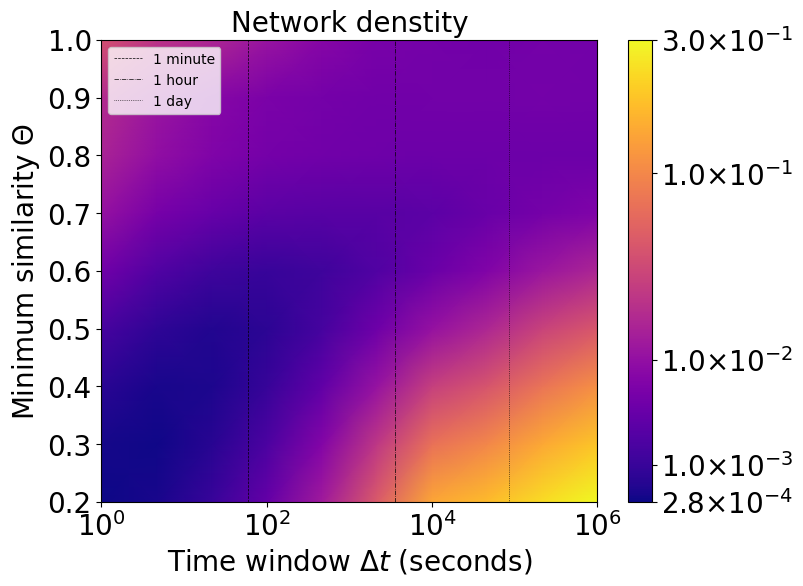

In [7]:
# Density heatmap

fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111)

# plot the first subplot
x = time_windows
y = min_similarities
# get the data for the subplots
data_d = heatmap[:,:,1].T
data_p = heatmap[:,:,2].T
data_N = heatmap[:,:,0].T


power_data_d = np.power(data_d, lambda_value)
im1 = ax1.pcolormesh(x, y, power_data_d, shading='gouraud', cmap='plasma')
ax1.set_title(r'Network denstity', fontsize=COMMONFONTSIZE)
ax1.set_xlabel(r'Time window $\Delta t$ (seconds)', fontsize=COMMONFONTSIZE)
ax1.set_xscale('log')
ax1.set_ylabel(r'Minimum similarity $\Theta$', fontsize=COMMONFONTSIZE)
ax1.tick_params(axis='both', which='major', labelsize=COMMONFONTSIZE)

# Calculate tick locations in the original data
min_value = data_d.min()
max_value = data_d.max()
min_exp = np.ceil(np.log10(min_value))
max_exp = np.floor(np.log10(max_value))
tick_locations_original = [10**i for i in np.arange(min_exp, max_exp + 1)]
tick_locations_original = [min_value] + tick_locations_original + [max_value]

# Calculate corresponding tick locations in the transformed data
tick_locations_transformed = np.power(tick_locations_original, lambda_value)

# Update the colorbar ticks
cbar = fig1.colorbar(im1, ax=ax1)
cbar.set_ticks(tick_locations_transformed)
cbar.ax.tick_params(labelsize=COMMONFONTSIZE)

# Update the colorbar labels to display the original data range
cbar.ax.yaxis.set_major_formatter(FuncFormatter(power_tick_formatter_bis))

# add vertical lines to the plot
for (tw, ls, des) in [(60,'--','1 minute'), (3600,'-.','1 hour'), (86400,':','1 day')]:
    ax1.axvline(tw, color='k', linestyle=ls, linewidth=0.5, label="{}".format(des))
# add legend
ax1.legend(loc='upper left')

# save the first subplot as a PNG/PDF file
plt.savefig('./intermediate_results/RSN_network_density.png', bbox_inches='tight')
plt.savefig('./intermediate_results/RSN_network_density.pdf', bbox_inches='tight')

# show the png file in the notebook
from IPython.display import Image
Image(filename='./intermediate_results/RSN_network_density.png')

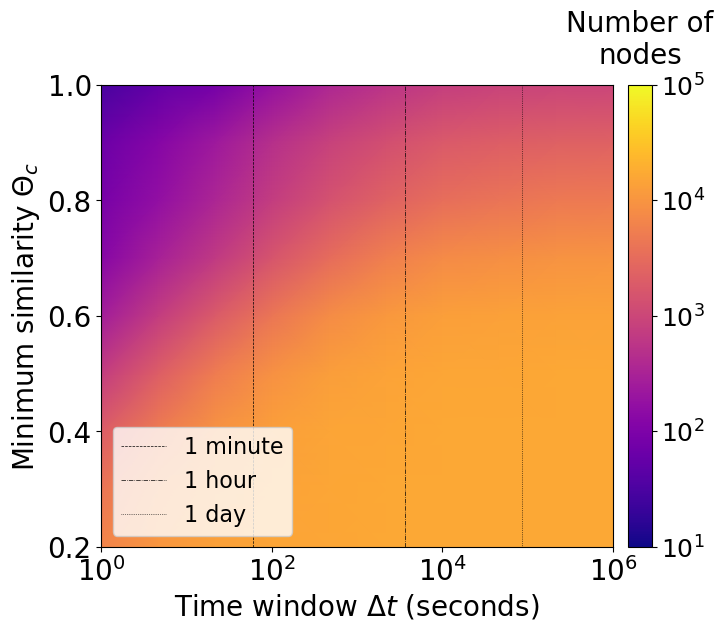

In [9]:
###  Number of nodes - using log trf for better visualization
### ---------------------------------------------------------
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(111)

## Main data
log_data_N = np.log10(data_N)
tick_locations = np.arange(np.floor(log_data_N.min()), np.ceil(log_data_N.max()) + 1)

vmin = tick_locations.min()
vmax = tick_locations.max()
im2 = ax2.pcolormesh(x, y, log_data_N, shading='gouraud', cmap='plasma', vmin=vmin, vmax=vmax)
#ax2.set_title('Number of nodes', fontsize=COMMONFONTSIZE)
ax2.set_xlabel(r'Time window $\Delta t$ (seconds)', fontsize=COMMONFONTSIZE)
ax2.set_xscale('log')
ax2.set_ylabel(r'Minimum similarity $\Theta_c$', fontsize=COMMONFONTSIZE)
ax2.tick_params(axis='both', which='major', labelsize=COMMONFONTSIZE)
# limit the number of y-ticks to 3
ax2.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))

## Colorbar settings
# Calculate tick locations in the original data for the colorbar
cbar = fig2.colorbar(im2, ax=ax2, pad=0.025)
cbar.set_ticks(tick_locations[1:] ) # + [np.log10(log_data_N.max())]
cbar.ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter_bis))
cbar.ax.tick_params(labelsize=COMMONFONTSIZE - 2)
cbar_title = cbar.ax.set_title("Number of\nnodes", fontsize=COMMONFONTSIZE, pad=15) # Place a title on the colorbar

# new version
cbar.set_ticks(tick_locations )
cbar.ax.set_yticklabels(["$10^{{{}}}$".format(int(np.round(x))) for x in tick_locations])

# add vertical lines to the plot
for (tw, ls, des) in [(60,'--','1 minute'), (3600,'-.','1 hour'), (86400,':','1 day')]:
    ax2.axvline(tw, color='k', linestyle=ls, linewidth=0.5, label="{}".format(des))
# add legend
ax2.legend(loc='lower left', fontsize=COMMONFONTSIZE-LEGENDCORRECTIONSIZE)

# save the second subplot as a PDF file
plt.savefig('./intermediate_results/RSN_param_{}_nodes_n.png'.format(EMBED_SHORT), bbox_inches='tight')
plt.show()
plt.close(fig2)

# show the png file in the notebook
Image(filename='./intermediate_results/RSN_param_{}_nodes_n.png'.format(EMBED_SHORT))

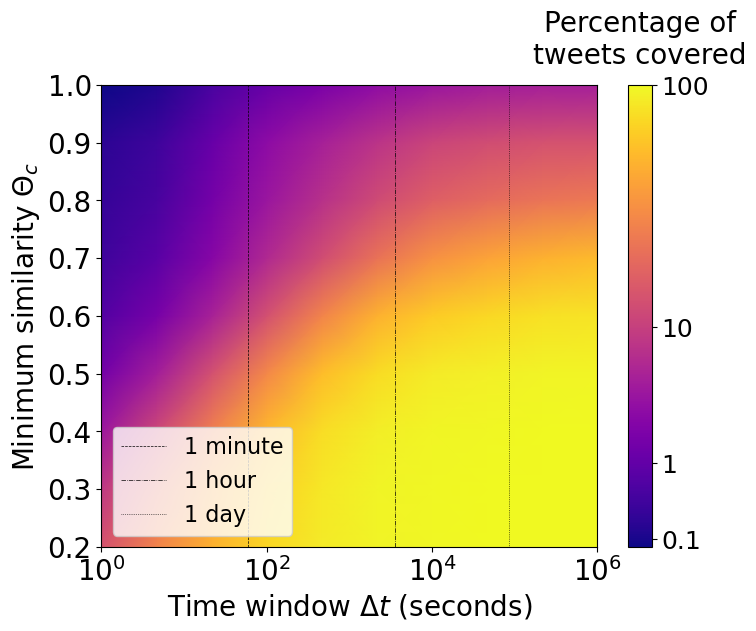

In [10]:
### Percentage of all tweets covered - better percentage polot using (sqrt) trf
### ---------------------------------------------------------------------------
fig3 = plt.figure(figsize=(8, 6))
ax3 = fig3.add_subplot(111)
power_data = np.power(data_p*100, lambda_value)

# Update the pcolormesh call to use the power-transformed data
im3 = ax3.pcolormesh(x, y, power_data, shading='gouraud', cmap='plasma')
#ax3.set_title(r'Percentage of all tweets covered', fontsize=COMMONFONTSIZE)
ax3.set_xlabel(r'Time window $\Delta t$ (seconds)', fontsize=COMMONFONTSIZE)
ax3.set_xscale('log')
ax3.set_ylabel(r'Minimum similarity $\Theta_c$', fontsize=COMMONFONTSIZE)
ax3.tick_params(axis='both', which='major', labelsize=COMMONFONTSIZE)
# Calculate tick locations in the original data
min_value = data_p.min() * 100
max_value = data_p.max() * 100
min_exp = np.ceil(np.log10(min_value))
max_exp = np.floor(np.log10(max_value))
tick_locations_original = [10**i for i in np.arange(min_exp, max_exp + 1)]
tick_locations_original = [min_value] + tick_locations_original + [max_value] # removed   for beautify

# Calculate corresponding tick locations in the transformed data
tick_locations_transformed = np.power(tick_locations_original, lambda_value)

# Update the colorbar ticks
cbar = fig3.colorbar(im3, ax=ax3)
cbar.set_ticks(tick_locations_transformed[1:]) # dropped the first tick for beautify
cbar.ax.tick_params(labelsize=COMMONFONTSIZE)
cbar.ax.tick_params(labelsize=COMMONFONTSIZE - 2)
cbar_title = cbar.ax.set_title("Percentage of\ntweets covered", fontsize=COMMONFONTSIZE, pad=15) # Place a title on the colorbar

# Update the colorbar labels to display the original data range
cbar.ax.yaxis.set_major_formatter(FuncFormatter(power_tick_formatter_bis))
# UPDATE more
cbar.set_ticks(tick_locations_transformed[1:])
cbar.ax.set_yticklabels(["{}".format(np.round(x, decimals=1)) if x < 1 else "{}".format(int(np.round(x))) for x in tick_locations_original[1:]])




# add vertical lines to the plot
for (tw, ls, des) in [(60,'--','1 minute'), (3600,'-.','1 hour'), (86400,':','1 day')]:
    ax3.axvline(tw, color='k', linestyle=ls, linewidth=0.5, label="{}".format(des))
# add legend
ax3.legend(loc='lower left', fontsize=COMMONFONTSIZE-LEGENDCORRECTIONSIZE)

# save the thrid subplot as a PDF file
plt.savefig('./intermediate_results/RSN_param_{}_percentage_n.png'.format(EMBED_SHORT), bbox_inches='tight')
plt.show()
plt.close(fig3)

# show the png file in the notebook
Image(filename='./intermediate_results/RSN_param_{}_percentage_n.png'.format(EMBED_SHORT))

### Analyzing the most prolific users.
This can be done in the same way as before, by looking at in- and out-degree and their weighted equivalents.

In [17]:
# helper function
def infer_weigthed_degree_and_degree(node_df, edge_df):
    # add indegree and outdegree to the node dataframe
    node_df["indegree"] =  node_df["node_id"].map(edge_df.groupby("target")["source"].count())
    node_df["outdegree"] = node_df["node_id"].map(edge_df.groupby("source")["target"].count())
    node_df["indegree"] =  node_df["indegree"].fillna(0)
    node_df["outdegree"] = node_df["outdegree"].fillna(0)
    # add weighted indegree and outdegree to the node dataframe
    node_df["weighted_indegree"] =  node_df["node_id"].map(edge_df.groupby("target")["weight"].sum())
    node_df["weighted_outdegree"] = node_df["node_id"].map(edge_df.groupby("source")["weight"].sum())
    node_df["weighted_indegree"] =  node_df["weighted_indegree"].fillna(0)
    node_df["weighted_outdegree"] = node_df["weighted_outdegree"].fillna(0)
    # add ranking to the node dataframe
    node_df["indegree_rank"] =  node_df["indegree"].rank(ascending=False)
    node_df["outdegree_rank"] = node_df["outdegree"].rank(ascending=False)
    
    return node_df


def generate_distribution(node_df, column_name):
    # get the values
    values, counts = cb.np.unique(node_df[column_name], return_counts=True)
    # get the counts
    distribution = counts / sum(counts)
    
    return values, counts, distribution


We can get an idea of the most profilic users from the updated dataframe.

In [21]:
udf_ranked = infer_weigthed_degree_and_degree(udf, edf)

## Combining the coordinated behavior networks
It can also be interesting to analyze if there is an overlap between the networks.

In [24]:
# obtain the rapid-retweet network data
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt


# Parameters
MW = 2 # min edge weight
TW = cb.datetime.timedelta(seconds=3600) # 1 hour time window
EMBEDDING_COL = "paraphrase-multilingual-mpnet-base-v2"
THETA = 0.8 # minimum similarity threshold 
QUERIES = [cb.OR_QUERY, cb.RP_QUERY, cb.QT_QUERY]

# generate both networks (can take a while, when not working on GPU)
node_df, edgelist,_ =  cb.rapid_retweet_network_data(mycol, myusercol, query=cb.RT_QUERY,  min_weight=MW, time_window=TW,  write_to_file=False)
udf, edf  =          cb.rapid_semantic_network_data(msgcol, usrcol,  queries=QUERIES,    min_weight=MW, time_window=TW,  write_to_file=False, allow_self_loops=False, embedding_column=EMBEDDING_COL, theta=THETA)


In [25]:
# intersection counts 
print("retweet network nodes:  {}".format(len(set(node_df.username.values))))
print("semantic network nodes: {}".format(len(set(udf.username.values))))
print("intersection:           {}".format(len(set(node_df.username.values).intersection(set(udf.username.values)))))
print("union (E[node count]):  {}".format(len(set(node_df.username.values).union(set(udf.username.values)))))

joined_node_df = node_df.merge(udf, on="username", how="outer", suffixes=("_retweet", "_semantic"))
print("joined_df:              {}".format(len(joined_node_df)))

# make the column 'name' base on name_retweet and name_semantic columns
joined_node_df["name"] = joined_node_df["name_retweet"].fillna(joined_node_df["name_semantic"])
# do the stame for the columns 'status'
joined_node_df["status"] = joined_node_df["status_retweet"].fillna(joined_node_df["status_semantic"])


## dealing with the common nodes between the networks
semantic_to_common_map = {}
# start with the nodes that are in both networks
for (_,row) in joined_node_df[(~joined_node_df.status_retweet.isna()) & (~joined_node_df.status_semantic.isna())].iterrows():
    semantic_to_common_map[row.node_id_semantic] = row.node_id_retweet
n_shared =  len(semantic_to_common_map)
print("shared nodes: {} ({:.2f}% of rapid retweet nodes and {:.2f}% of rapid semantic)".format(n_shared, 100*n_shared/len(node_df), 100*n_shared/len(udf)))
# deal with those only in the semantic network
for (_,row) in joined_node_df[(joined_node_df.status_retweet.isna()) & (~joined_node_df.status_semantic.isna())].iterrows():
    semantic_to_common_map[row.node_id_semantic] = len(semantic_to_common_map) + len(node_df) - n_shared
joined_node_df["node_id_semantic_mapped"] = joined_node_df["node_id_semantic"].map(semantic_to_common_map)


# make the column 'node_id' base on node_id_retweet and node_id_semantic_mapped columns
joined_node_df["node_id"] = joined_node_df["node_id_retweet"].fillna(joined_node_df["node_id_semantic_mapped"])
# make the column 'user_id' base on user_id_retweet and user_id_semantic columns
joined_node_df["user_id"] = joined_node_df["user_id_retweet"].fillna(joined_node_df["user_id_semantic"])

# reorganize the columns, first node_id, then user_id, then username, then name, then status. 
joined_node_df = joined_node_df[["node_id", "user_id", "username", "name", "status"]]
joined_node_df

## global joined edgelist
edgelist.rename(columns={"weight": "weight_retweet"}, inplace=True)

# map the semantic edgelist
edf["source_mapped"] = edf["source"].map(semantic_to_common_map)
edf["target_mapped"] = edf["target"].map(semantic_to_common_map)
edf["weight_semantic"] = edf["weight"]

combined_edge_df = cb.pd.merge(edgelist, edf, left_on=['source', 'target'], right_on=['source_mapped', 'target_mapped'], how='outer', suffixes=('_retweet', '_semantic'))

# rename source_retweet to source
combined_edge_df.rename(columns={"source_retweet": "source"}, inplace=True)
# rename target_retweet to target
combined_edge_df.rename(columns={"target_retweet": "target"}, inplace=True)
# fill in the nan value by source_mapped
combined_edge_df["source"] = combined_edge_df["source"].fillna(combined_edge_df["source_mapped"])
# fill in the nan value by target_mapped
combined_edge_df["target"] = combined_edge_df["target"].fillna(combined_edge_df["target_mapped"])
# fill the nan value of weight_retweet by 0
combined_edge_df["weight_retweet"] = combined_edge_df["weight_retweet"].fillna(0)
# fill the nan value of weight_semantic by 0
combined_edge_df["weight_semantic"] = combined_edge_df["weight_semantic"].fillna(0)
# compute the combined weights
combined_edge_df["weight"] = combined_edge_df["weight_retweet"] + combined_edge_df["weight_semantic"]


retweet network nodes:  1025
semantic network nodes: 556
intersection:           95
union (E[node count]):  1486
joined_df:              1486
shared nodes: 95 (9.27% of rapid retweet nodes and 17.09% of rapid semantic)


It turns out that the overlap between the networks is limited.

# Bipartite user-domain network
The way news is shared can also be a good indication of coordinated behavior. We will explore this here.

## Setup

In [28]:
import bipartite_domains as bd
from datetime import datetime
# establish the connection to the database
Client = bd.pymongo.MongoClient('localhost', 27017)
# verify proper connection
print("Connected to server running MongoDB {} using pymongo {}. Available databases: \n - {}".format(   Client.server_info()['version'], 
                                                                                                        bd.pymongo.version, str.join("\n - ", 
                                                                                                        Client.list_database_names())))
# proper db and collection
mydb = Client["small"]
mycol = mydb["tweets"]

# link it to the augmented user database
metadb = Client["metajurgen"]
metadb_authorcol = metadb["authors"] # users
metadb_domaincol = metadb["domains"] # domains




# filter out the excluded dates
start_forbidden_date = datetime(2021, 9, 28)
end_forbidden_date = datetime(2021, 10, 1)
# General query filter
EXCLUSION_FILTER = {"$or" : [
        {"created_at": {"$lt": start_forbidden_date}},
        {"created_at": {"$gte": end_forbidden_date}}
    ]}

# Queries that will be used to fetch tweets containing urls:
OR_QUERY = {**bd.OR_QUERY.query(), **EXCLUSION_FILTER}
RT_QUERY = {**bd.RT_QUERY.query(), **EXCLUSION_FILTER}
RP_QUERY = {**bd.RP_QUERY.query(), **EXCLUSION_FILTER}

# Shortening services
short_domains = set(['trib.al','dlvr.it', 'bit.ly', 'buff.ly','zpr.io', 'ift.tt', 't.co', 'ow.ly', 'goo.gl', 'fb.me', 'tinyurl.com', 'ow.ly', 'wp.me', 'amzn.to', 'bit.ly', 'buff.ly', 'dlvr.it', 'fb.me', 'goo.gl', 'ift.tt', 'ow.ly', 't.co', 'tinyurl.com', 'trib.al', 'wp.me', 'zpr.io', 'urlz.fr', 'cutt.ly', 'linktr.ee', 'ap.lc', 'eepurl.com', 'tl.gd', 'smarturl.it'])
with open(file="./list_shorterers.txt", mode="r") as f:
    sd = map(lambda x : x.strip(),f.readlines())
DSS = short_domains.union(set(list(sd))) # DSS: Domain Shortening Services

# known domains to reject
FB = set(["twitter.com"]) # FB: ForBidden Domains

Connected to server running MongoDB 6.0.16 using pymongo 3.12.0. Available databases: 
 - admin
 - config
 - large
 - local
 - metajurgen
 - small


## Generate the bipartite network
This process assumes that 'metadb' has additional information regarding the users, such as their status, their bot like behavior according to Botomoeter or other methods etc.

In [31]:
# basic bipartite graph & dataframe describing the nodes
G, df = bd.bipartite_user_domain_graph(mycol, directed=False, 
                                            include_original=True, include_retweets=True, include_replies=True,
                                            or_query=OR_QUERY, rt_query=RT_QUERY, rp_query=RP_QUERY, 
                                            expand_shortened_links=False, # omitted for demo speed
                                            domain_shortening_services=DSS, 
                                            rejected_domains=FB, 
                                            Nlimit=5000 # limit the number of nodes, for demo speed
                                            )

In [34]:
# add extra metadata
bd.add_domain_meta_info(G, df, metadb_authorcol)
bd.add_user_meta_info(G, df, metadb_authorcol)
df["1-ratio_active_users"] = 1 - df["ratio_active_users"]

# and write to file
bd.write_out_node_edge_lists("./intermediate_results/bipartite_webpage_net_all", G, df, add_DTG=False)
bd.myserializer("./intermediate_results/bipartite_webpage_net_all", G, df, add_DTG=False)

# project on the domain layer
G_p_d, df_p_d = bd.project_bipartite_network(G, df, layer="domain",keepweights=True)
df_p_d["degree"] =  df_p_d.apply(lambda x : G_p_d.degree(x["node_id"]), axis=1)
# store the projected network and its node properties as CSV and pickle
bd.write_out_node_edge_lists("./intermediate_results/bipartite_network_domainproj", G_p_d, df_p_d, add_DTG=False)
bd.myserializer("./intermediate_results/bipartite_network_domainproj", G_p_d, df_p_d, add_DTG=False)

None

## Analysis of the bipartite user-website network

In [36]:
from IPython.display import Markdown
import igraph as ig
import leidenalg as la

Descriptives

In [37]:
# Load the network and dataframe from file
fpath = "./intermediate_results/bipartite_webpage_net_all.pkl"
G, df =         bd.mydeserializer(fpath)
G_p_d, df_p_d = bd.mydeserializer("./intermediate_results/bipartite_network_domainproj.pkl")

df['non_active'] = df["closed_users"] + df["suspended_users"]
df_p_d["non_active"] = df_p_d["closed_users"] + df_p_d["suspended_users"]
Markdown("""
Bipartite network of users and domains (webpages) with the following properties:
- nodes: {usernodes} users, {domainnodes} domains
- edges: {edgenodes} edges
         
Projecting the network on the domain layer yields the following network:
- nodes: {domainnodes} domains
- edges: {domainedges} edges
- isolated nodes: {isolatednodes} ({isolatedpercentage:.2f} %)nodes
""".format(usernodes=df[df["kind"] == "user"].shape[0], 
           domainnodes=df[df["kind"] == "domain"].shape[0], 
           edgenodes=G.numberOfEdges(), 
           domainedges=G_p_d.numberOfEdges(), 
           isolatednodes=df_p_d[df_p_d["degree"] == 0].shape[0], isolatedpercentage=df_p_d[df_p_d["degree"] == 0].shape[0] / df_p_d.shape[0]*100))


Bipartite network of users and domains (webpages) with the following properties:
- nodes: 6631 users, 421 domains
- edges: 5916 edges
         
Projecting the network on the domain layer yields the following network:
- nodes: 421 domains
- edges: 1218 edges
- isolated nodes: 224 (53.21 %)nodes


Components

In [38]:

# convert the networkit graph to an igraph graph
edge_list = [(e[0],e[1]) for e in G_p_d.iterEdgesWeights()]
weights = [e[2] for e in G_p_d.iterEdgesWeights()]
G_p_d_ig = ig.Graph(G_p_d.numberOfNodes(), edges=edge_list,  edge_attrs={'weight': weights}, directed=G_p_d.isDirected())

# set the vertex attributes # FYI: weigth attributes are here: G.es["weight"]
#G_p_d_ig.vs["description"] = df_p_d["description"]
G_p_d_ig.vs["original_indices"] = df_p_d.node_id.to_list()

# get the components
components = G_p_d_ig.connected_components(mode='weak')
df_p_d["component"] = components.membership

# extract the extension od the description field
df_p_d["description_ext"] = df_p_d["description"].apply(lambda x : x.split(".")[-1])

# get the LCC
G_p_d_ig_LCC = components.giant()

Markdown("""
The largest component is component 0, which contains {largestcomponentnodes} nodes ({largestcomponentpercentage:.2f} %) and {largestcomponentedges} edges ({largestcomponentedgespercentage:.2f} % of the edges in the projected network)
""".format(largestcomponentnodes=G_p_d_ig_LCC.vcount(), largestcomponentpercentage=G_p_d_ig_LCC.vcount() / G_p_d.numberOfNodes() * 100, 
           largestcomponentedges=G_p_d_ig_LCC.ecount(), largestcomponentedgespercentage=G_p_d_ig_LCC.ecount() / G_p_d.numberOfEdges() * 100))



The largest component is component 0, which contains 186 nodes (44.18 %) and 1212 edges (99.51 % of the edges in the projected network)


In [40]:
# get communities using the Leiden algorithm of the largest component, accounting for edge weights
LCC_communities = la.find_partition(G_p_d_ig_LCC, la.ModularityVertexPartition, n_iterations=500)#, weights='weight')#, seed=161)

# message with the modularity score and the number of communities
print("""
Largest connected component of the retweet network: {} nodes
      
Number of communities: {}
Community sizes: {}
Modularity score: {:.4f}
      """.format(G_p_d_ig_LCC.vcount(), len(LCC_communities.sizes()), LCC_communities.sizes(), LCC_communities.modularity))



# Global community vector
glob_com_col = [0 for _ in range(G_p_d.numberOfNodes())]
# update the colors of the nodes in the largest component using their community membership
for i in range(G_p_d_ig_LCC.vcount()):
     glob_com_col[G_p_d_ig_LCC.vs[i]["original_indices"]] = LCC_communities.membership[i] + 1
# add community to the node_df
df_p_d['community'] = glob_com_col


Largest connected component of the retweet network: 186 nodes
      
Number of communities: 7
Community sizes: [49, 45, 36, 35, 9, 7, 5]
Modularity score: 0.2772
      


## Statistically validated backbone analysis
We now apply the bipartite configuration model to extract the statistically significant edges (note that with a limited data selection, nothing will probably be significant, because each edge has a weight of one).

In [41]:
bd.apply_null_model("./intermediate_results/BP_network_domainproj_val", G, df, add_DTG=False)


                      This may cause some convergence issues.
                      Please use the full mode providing a biadjacency matrix or an edgelist, or clean your data from these nodes. 
                      
max rows error = 8.831285924770782e-09
max columns error = 5.702097496396163e-07
total error = 3.561381303862632e-06
Solver converged.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 421/421 [00:00<00:00, 2464.77it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PAR

No V-motifs will be validated. Try increasing alpha


In [42]:
# generate the validated domain projection network
# read up the edges
G_p_d_validated_edges = bd.pd.read_csv("./intermediate_results/BP_network_domainproj_val_domainproj_edges_filtered.csv", sep=";")

# construct the network
G_p_d_ig_validated = ig.Graph(G_p_d.numberOfNodes(), edges=zip(G_p_d_validated_edges.source, G_p_d_validated_edges.target), directed=False)

# find the components
components_validated = G_p_d_ig_validated.connected_components(mode='weak')

# identify the components that are not singletons
df_p_d["components_validated"] = components_validated.membership

In [43]:
# get the components with more than one node
validated_count_per_comp = df_p_d.aggregate({"components_validated": "value_counts"}).query("components_validated > 1")
# for each component, display the description of the domains in that component
msg = ""
for comp in validated_count_per_comp.index.to_list():
    if comp != 0:
        # add this to msg
        #"""Component {:3}: {} """.format(comp, ", ".join(df_p_d.query("component == {}".format(comp)).sort_values(by=["degree"], ascending=False).description.to_list()))
        msg += """Validated component {:3}: {} \n\n""".format(comp, ", ".join(df_p_d.query("components_validated == {}".format(comp)).sort_values(by=["degree"], ascending=False).description.to_list()))

Markdown(msg)

Validated component  91: lalibre.be, sudinfo.be, rtl.be 

Validated component  80: tscheldt.be, palnws.be 

Validated component 131: lesoir.be, rtbf.be 



## Illustration

/SSD-data/LLMfun/envs/jurgen2/lib/python3.11/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/SSD-data/LLMfun/envs/jurgen2/lib/python3.11/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/SSD-data/LLMfun/envs/jurgen2/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/SSD-data/LLMfun/envs/jurgen2/lib/python3.11/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future.

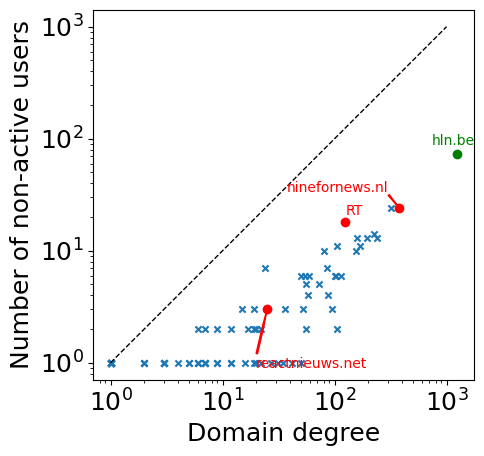

In [45]:
# make a plot of df, where the kind is "domain". The x-axis is the BP_degree, the y-axis is the 1-ratio_active_users
# xscale should be log
# yscale should be [0,1]
import matplotlib.pyplot as plt

p = df[df['kind'] == 'domain'].plot.scatter(x='BP_degree', y='non_active', marker='x')
p.set_xscale('log')
p.set_yscale('log')
localfontsize = 18
p.set_xlabel("Domain degree", fontsize=localfontsize)
p.set_ylabel("Number of non-active users", fontsize=localfontsize)
# set font size for labels
p.tick_params(axis='both', which='major', labelsize=localfontsize)
# set font size for axes labls

# add a diegonal line
p.plot([1, 1000], [1, 1000], color='black', linestyle='dashed', linewidth=1)

# add annotations to the plot
descriptor = "RT"
# scatter plot, but without filled circles
#

p.scatter([125], [12+6], marker='o', color='red')
# add text
p.text(125, 21, "RT", color='red', fontsize=10)

# add annontation to plot where the domain is "hln.be"
descriptor = "hln.be"
p.scatter(df[df['description'] == descriptor]['BP_degree'], df[df['description'] == descriptor]['non_active'], color='green', marker='o')
p.text(df[df['description'] == descriptor]['BP_degree']*0.6, df[df['description'] == descriptor]['non_active']*1.2, descriptor, color='green', fontsize=10)

# # add annotation to plot where the domain is "reactnews"
descriptor = "reactnieuws.net"
p.scatter(df[df['description'] == descriptor]['BP_degree'], df[df['description'] == descriptor]['non_active'], color='red', marker='o')
p.annotate(descriptor, xy=(df[df['description'] == descriptor]['BP_degree'], df[df['description'] == descriptor]['non_active']), 
           xytext=(df[df['description'] == descriptor]['BP_degree']*2.5, df[df['description'] == descriptor]['non_active']*0.3), 
           arrowprops=dict(facecolor='red', shrink=0.01, edgecolor='red', width=1, headwidth=1), color='red', fontsize=10, ha='center')

# add arrow annotation
descriptor = "ninefornews.nl"
p.scatter(df[df['description'] == descriptor]['BP_degree'], df[df['description'] == descriptor]['non_active'], color='red', marker='o')
p.annotate(descriptor, xy=(df[df['description'] == descriptor]['BP_degree'], df[df['description'] == descriptor]['non_active']), 
           xytext=(df[df['description'] == descriptor]['BP_degree']*0.8, df[df['description'] == descriptor]['non_active']*1.4), 
           arrowprops=dict(facecolor='red', shrink=0.01, edgecolor='red', width=1, headwidth=1), color='red', fontsize=10, ha='right')

# make the plot square
p.set_aspect('equal', adjustable='box')

# save the figure, without the extra white space
plt.savefig("./intermediate_results/domains_inactive.pdf", dpi=300, bbox_inches='tight')
#plt.savefig("./intermediate_results/2024-01-24_bipartite_network_domainproj.pdf", dpi=300)

